# LAB 4 - Matheus Gomes Maia
## ATIVIDADE
* 1 Execute o algoritmo ilustrado na Fig. 5.8 do livro texto (pag. 157) para gerar um índice similar o mostrado na Fig. 5.4 (pag. 134). Guarde o índice em disco em formato csv. (1 pt)
* 2 Implemente as abordagens de processamento de consulta documento-por-vez e termo-por-vez (Fig. 5.16 e 5.18). (2 pts)
    * Defina 5 consultas de um termo somente.
    * Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
    * Dê evidências de que sua implementação está correta.
    * Compare os tempos médios de execução e uso de memória de cada algoritmo.
* 3 Implemente uma das versões de consulta conjuntiva (AND) (Fig. 5.20 ou 5.21). (2 pts)
    * Defina 5 consultas conjuntivas (AND).
    * Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
    * Dê evidências de que sua implementação está correta.

## SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import re
from scipy.optimize import minimize_scalar
import seaborn as sns
pd.set_option("display.max_rows",40)

%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/maia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
data = pd.read_csv('../results_fornecida.csv')
data = data.drop_duplicates(subset='url', keep='last')


#Pre process news
# Tokenize, Join and Filter
# Words into a new data Frame
txt = [str(news) for news in data["text"].tolist()]
words = [nltk.word_tokenize(sentence) for sentence in txt]
words = [item for sublist in words for item in sublist] 
words = [word.lower() for word in words if (word.isalpha() and len(word)) > 2] 

# New Data frame with Word, Frequency and Ranking columns 
words_df = pd.DataFrame(words, columns=['word']) #All words
word_counts = words_df.word.value_counts().reset_index() #Join by word. Adds Frequency
word_counts.columns = ['Word', 'Freq'] #Naming columns 
word_counts['word_rank'] = word_counts.Freq.rank(ascending=False) #Adds ranking

## 1 Execute o algoritmo ilustrado na Fig. 5.8 do livro texto (pag. 157) para gerar um índice similar o mostrado na Fig. 5.4 (pag. 134). Guarde o índice em disco em formato csv. (1 pt)

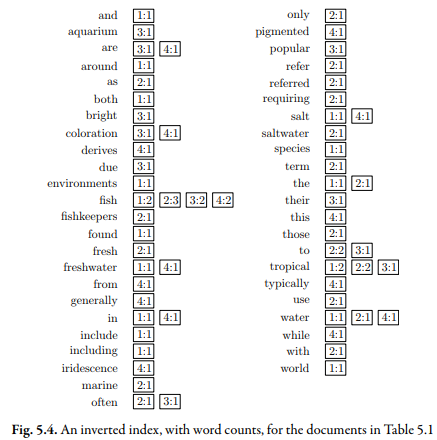 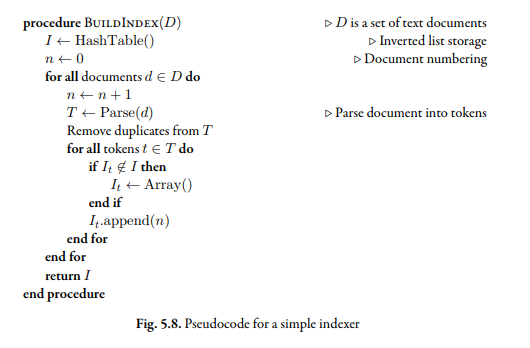

In [3]:
def parse(news):
    words = [nltk.word_tokenize(news)]
    words = [item for sublist in words for item in sublist] 
    words = [word.lower() for word in words if (word.isalpha() and len(word)) > 2]
    return words
    

def buidIndex(txt):
    I = {}
    n = 0
    for news in txt:
        T = parse(news)
        for token in T:
            if(token not in I.keys()):
                I[token] = [n]
            else:
                I[token].append(n)
        n += 1
    return I

invIndex = buidIndex(txt)
print(invIndex)

{'descontentes': [19, 204], 'martínez': [3, 64, 64, 64, 64, 187, 187, 187, 187, 248, 248, 248, 248, 248, 248, 248], 'despertadas': [91, 229], 'destoa': [222], 'latinobarómetro': [9], 'hipocrisia': [62, 91], 'hesitação': [7], 'estáveis': [27, 27], 'urina': [18, 107, 118, 181], 'loteamento': [114], 'usp': [2, 2, 215, 215, 215, 238, 238, 238], 'renacionalizar': [128], 'estilização': [188], 'enganadas': [248], 'interessado': [22, 117, 150, 161, 247], 'empresarial': [41, 85, 124, 124, 131, 132, 132, 218], 'enfermidades': [69, 178], 'regressará': [76, 199], 'escritas': [104, 166, 174, 197], 'corrida': [114, 136, 184, 195, 206, 225], 'vinculado': [28, 129, 216, 219], 'doze': [167], 'bochum': [28], 'braga': [14, 206], 'servia': [5], 'natureza': [24, 44, 59, 64, 68, 88, 88, 88, 137, 160, 229], 'china': [19, 22, 31, 55, 68, 68, 88, 118, 118, 118, 126, 128, 133, 135, 143], 'complicadíssima': [35], 'exige': [58, 79, 87, 107, 109, 136, 152, 196, 241], 'marcada': [5, 61, 83, 123, 200, 211, 245], 'tw

In [4]:
invIndex["juíza"]

[0, 0, 1]

##  2 Implemente as abordagens de processamento de consulta documento-por-vez e termo-por-vez (Fig. 5.16 e 5.18). (2 pts)
    * Defina 5 consultas de um termo somente.
    * Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
    * Dê evidências de que sua implementação está correta.
    * Compare os tempos médios de execução e uso de memória de cada algoritmo.

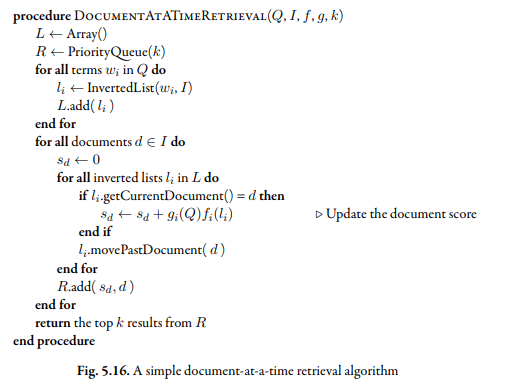
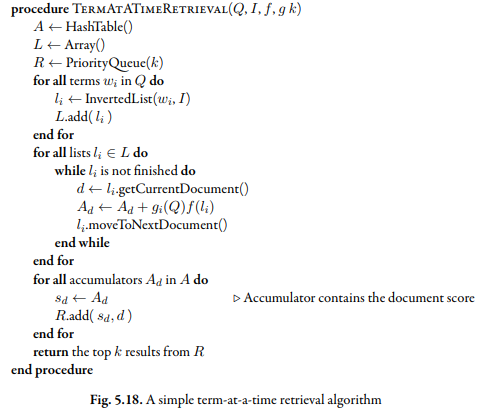

As implementações são bem diferentes por causa da linguagem. Mas a intuição é a mesma

In [5]:
def docAtTime(Q, Inv, k):
    L = { key: Inv[key] for key in Q if key in Inv.keys() } #Filtra entrys de interesse no IndexInvertido
    R = {}
    docs_in_L = [item for sublist in L.values() for item in sublist] # Todos os docs de interesse em L
    for doc in docs_in_L: #Para cada doc
        for term in L.keys(): # Itera pelos termos
            if doc in L[term]: #  Se algum termos da Query esta presentes no doc
                # Acumula o score
                if doc in R.keys() :
                    R[doc] += 1
                else:
                    R[doc] = 0
    return (sorted(R, key=lambda k: R[k], reverse=True))[:k]

docAtTime("Juíz meu cara".split(), invIndex, 3)


[248, 194, 150]

In [6]:
def termAtTime(Q, Inv, k):
    L = { key: Inv[key] for key in Q if key in Inv.keys() } #Filtra entrys de interesse no IndexInvertido
    R = {}
    for term in L.keys(): # Para cada termo
            for doc in L[term]: #  Itera pelos docs que tem o termo
                # Acumula o score
                if doc in R.keys() :
                    R[doc] += 1
                else:
                    R[doc] = 0
    if(k > len(R.keys())):
        k = len(R.keys())
    return (sorted(R, key=lambda k: R[k], reverse=True))[:k]

termAtTime("com".split(), invIndex, 3)

[248, 62, 68]

### Defina 5 consultas de um termo somente  e execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).

In [7]:
querys_test = ["lista", "com", "varias", "gato", "mano"]
res_doc = []
res_term = []
for query in querys_test:
    res_doc.append(query +": "+str(docAtTime(query.split(), invIndex, 10)))
    res_term.append(query +": "+ str(termAtTime(query.split(), invIndex, 10)))
print(res_doc)
print(res_term)


['lista: [129, 194, 36, 6, 102, 241, 170, 44, 109, 238]', 'com: [248, 62, 68, 165, 150, 18, 216, 197, 194, 6]', 'varias: [247]', 'gato: [196]', 'mano: [120, 44]']
['lista: [129, 194, 36, 6, 102, 241, 170, 44, 109, 238]', 'com: [248, 62, 68, 165, 150, 18, 216, 197, 194, 6]', 'varias: [247]', 'gato: [196]', 'mano: [120, 44]']


### Dê evidências de que sua implementação está correta.

Teste:
Imprimir o resultado da consulta por palavras que escolhi.
    A consulta mostra os documentos que tem o termo pesquisado. 
Ir em TODOS os documentos e ver a quantidade de vezes que o termo aparece em cada um.
Ordenar por quantidade de vezes que o termo aparece.
Como a ordem é a mesma, utilizando a consulta e fazendo essa verificação por força bruta, a consulta realmente faz oq deveria.
Assim espero :P

In [8]:


def coutWordInTxts(word, txtList): 
    freqDict = {}
    for txtsI in range(len(txtList)):
        #print("Quantidade de  "+ word + " no documento: " + str(txtsI) + " ", end='')
        txt_list = [word.lower() for word in txtList[txtsI].split() if (word.isalpha() and len(word)) > 2]
        count = 0
        for x in txt_list:
            if(word == x):
                count += 1
        if(count > 0):
            freqDict[txtsI] = count
    return freqDict

teste = ["com", "gato", "prova"]
for X in teste:
    freqDict = coutWordInTxts(X, txt)
    print("Resultado usando força bruta, procurando por \"" + X + "\":")
    print(sorted(freqDict, key=lambda k: freqDict[k], reverse=True)[:10])
    print("Resultado usando consulta na lista invertida, procurando por \"" + X + "\":")
    res_consulta = termAtTime(X.split(), invIndex, 10)
    print(res_consulta)
    print()
    


Resultado usando força bruta, procurando por "com":
[248, 62, 68, 165, 150, 18, 216, 197, 194, 6]
Resultado usando consulta na lista invertida, procurando por "com":
[248, 62, 68, 165, 150, 18, 216, 197, 194, 6]

Resultado usando força bruta, procurando por "gato":
[196]
Resultado usando consulta na lista invertida, procurando por "gato":
[196]

Resultado usando força bruta, procurando por "prova":
[165, 128, 129, 177, 40, 242, 171, 109, 46, 15]
Resultado usando consulta na lista invertida, procurando por "prova":
[165, 128, 129, 177, 40, 242, 171, 109, 46, 15]



### Compare os tempos médios de execução e uso de memória de cada algoritmo.


In [9]:
import time
from memory_profiler import memory_usage


def manyTimesTerm():
    for x in range(10000):
        termAtTime("com", invIndex, 10)
        
def manyTimesDoc():
    for x in range(10000):
        termAtTime("com", invIndex, 10)


time_start = time.clock()
m = memory_usage((manyTimesDoc, ()))
time_elapsed = (time.clock() - time_start)
print("PER DOC: ", m, time_elapsed)

time_start = time.clock()
m = memory_usage((manyTimesTerm, ()))
time_elapsed = (time.clock() - time_start)
print("PER TERM", m, time_elapsed)

PER DOC:  [184.12890625, 184.2265625, 184.2265625, 184.2265625, 184.2265625] 0.056229000000000084
PER TERM [184.43359375, 184.43359375, 184.43359375, 184.43359375, 184.43359375] 0.05795499999999976


Consulta por termo tem a execução mais rápida.

Não consegui ver diferença no uso de memória utlizando a coleção que estou usando, mas em teoria por termo utiliza mais memória.

## 3 Implemente uma das versões de consulta conjuntiva (AND) (Fig. 5.20 ou 5.21). (2 pts)
* Defina 5 consultas conjuntivas (AND).
* Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
* Dê evidências de que sua implementação está correta.

In [10]:
def termAtTimeConj(Q, Inv, k):
    L = { key: Inv[key] for key in Q if key in Inv.keys() } #Filtra entrys de interesse no IndexInvertido
    R = {}
    to_remove = []
    docs_in_L = [item for sublist in L.values() for item in sublist]
    #print(L)
    for term in L.keys(): # Para cada termo
            for doc in docs_in_L: #  Itera pelos docs que tem o termo
                if doc in L[term]:
                    # Acumula o score
                    if doc in R.keys():
                        R[doc] += 1
                    else:
                        R[doc] = 0
                else:
                    to_remove.append(doc)
    if(k > len(R.keys())):
        k = len(R.keys())
    raw = (sorted(R, key=lambda k: R[k], reverse=True))
    return [filtered for filtered in raw if filtered not in to_remove][:k]

termAtTimeConj("desobedece princípio prevalência ".split(), invIndex, 3)

[0]

* Defina 5 consultas conjuntivas (AND).
* Execute as 5 consultas em cada algoritmo retornando os top-10 documentos (parâmetro k do algoritmo).
* Dê evidências de que sua implementação está correta.

In [11]:
querys_test = [txt[0][0:100], txt[1][0:100], txt[2][0:100], txt[3][0:100], txt[4][0:100]]
for query in querys_test:
    print(query +": "+str(termAtTimeConj(query.split(), invIndex, 10)))


A juíza federal Ivani Silva da Luz  de Brasília  proibiu em caráter liminar nesta sexta-feira as For: [0]
Menos de 24 horas depois de a juíza federal Ivani Silva da Luz   que completa 55 anos neste domingo : [1]
Quando  determinou que  de 31 de março 1964  uma estratégia polêmica de mudar a narrativa sobre como: [2]
Quando  era pequeno   Luisa e  Gabriel se preocupavam que o menino piscasse tanto. Seu pai chegou a : [3]
Desde a manhã da última segunda-feira     e   sucessos mundiais de   pararam de tocar em algumas rád: [4]


Quando se utiliza query com o começo dos textos dos documentos só se retorna aquele documento. Isso da evidência de que a implementação está correta.